#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 09
**CH09A Estimating gender and age differences in earnings**

using the cps-earnings dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/cps-earnings/clean/"
data_out = dirname + "da_case_studies/ch09-gender-age-earnings/"
output = dirname + "da_case_studies/ch09-gender-age-earnings/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
import py_helper_functions as da
sns.set_theme(rc=da.da_theme, palette=da.color)

In [4]:
data_all = pd.read_csv(data_in + "morg-2014-emp.csv")
#data_all = pd.read_csv("https://osf.io/download/4ay9x/")



### SELECT OCCUPATION

keep only two occupation types: Market research analysts and marketing specialists and Computer and Mathematical Occupations

In [5]:
data_all.loc[data_all["occ2012"] == 735, "sample"] = 1
data_all.loc[
    ((data_all["occ2012"] >= 1005) & (data_all["occ2012"] <= 1240)), "sample"
] = 2
data_all.loc[data_all["sample"].isna(), "sample"] = 0


In [6]:
data_all = data_all.loc[
    (data_all["sample"] == 1) | (data_all["sample"] == 2), :
].reset_index(drop=True)


In [7]:
data_all["sample"].value_counts()


sample
2.0    4740
1.0     281
Name: count, dtype: int64

In [8]:
data_all["female"] = (data_all["sex"] == 2).astype(int)
data_all["w"] = data_all["earnwke"] / data_all["uhours"]
data_all["lnw"] = np.log(data_all["w"])
data_all["agesq"] = np.power(data_all["age"], 2)


In [9]:
i = 1
data = data_all.loc[data_all["sample"] == i, :].reset_index(drop=True)
data.to_csv(data_out + "earnings_inference.csv", index=False)


### DISTRIBUTION OF EARNINGS

In [10]:
data.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656
std,709.545222,10.325838,14.712495
min,40.000000,5.000000,7.250000
25%,700.000000,40.000000,17.788250
50%,1096.150000,40.000000,25.950000
75%,1538.000000,40.000000,37.019000
max,2884.610000,80.000000,84.600000


In [11]:
data.loc[data["w"] >= 1, ["earnwke", "uhours", "w"]].describe()


,earnwke,uhours,w
count,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656
std,709.545222,10.325838,14.712495
min,40.000000,5.000000,7.250000
25%,700.000000,40.000000,17.788250
50%,1096.150000,40.000000,25.950000
75%,1538.000000,40.000000,37.019000
max,2884.610000,80.000000,84.600000


In [12]:
data["female"].value_counts()


female
1    172
0    109
Name: count, dtype: int64

In [13]:
data.groupby(["occ2012", "female"]).size()


occ2012  female
735      0         109
         1         172
dtype: int64

### Linear regressions

In [14]:
reg1 = smf.ols(formula="lnw~female", data=data).fit()
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.390
Date:                Mon, 03 Mar 2025   Prob (F-statistic):             0.0666
Time:                        14:14:21   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.048     69.004      0.000       3.220       3.409
female        -0.1131      0.061     -1.841      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
reg2 = smf.ols(formula="lnw~female", data=data).fit(cov_type="HC1")
reg2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.347
Date:                Mon, 03 Mar 2025   Prob (F-statistic):             0.0684
Time:                        14:14:21   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.049     67.810      0.000       3.219       3.411
female        -0.1131      0.062     -1.829      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Table 9.1 Wage and gender gap baseline regression

In [16]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


In [17]:
reg3 = smf.ols(formula="lnw~age", data=data).fit(cov_type="HC1")
reg3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     26.36
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           5.31e-07
Time:                        14:14:21   Log-Likelihood:                -191.01
No. Observations:                 281   AIC:                             386.0
Df Residuals:                     279   BIC:                             393.3
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7317      0.101     27.006      0.000       2.533       2.930
age            0.0135      0.003      5.135      0.000       0.008       0.019
==============================================================================
Omnibus:                        1.782   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.708
Skew:                          -0.109   Prob(JB):                        0.426
Kurtosis:                       2.687   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [18]:
reg4 = smf.ols(formula="lnw~age+agesq", data=data).fit(cov_type="HC1")
reg4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     27.47
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           1.29e-11
Time:                        14:14:21   Log-Likelihood:                -179.58
No. Observations:                 281   AIC:                             365.2
Df Residuals:                     278   BIC:                             376.1
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1935      0.341      3.499      0.000       0.525       1.862
age            0.0962      0.018      5.360      0.000       0.061       0.131
agesq         -0.0010      0.000     -4.608      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        0.304   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.353
Skew:                          -0.078   Prob(JB):                        0.838
Kurtosis:                       2.924   Cond. No.                     2.22e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
from py_helper_functions import lspline

In [20]:
reg5 = smf.ols(formula="lnw~lspline(age,[30,40])", data=data).fit(cov_type="HC1")
reg5.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     19.33
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           2.07e-11
Time:                        14:14:21   Log-Likelihood:                -178.88
No. Observations:                 281   AIC:                             365.8
Df Residuals:                     277   BIC:                             380.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.3834      0.369      3.753      0.000       0.661       2.106
lspline(age, [30, 40])[0]     0.0624      0.014      4.559      0.000       0.036       0.089
lspline(age, [30, 40])[1]     0.0165      0.010      1.680      0.093      -0.003       0.036
lspline(age, [30, 40])[2]    -0.0026      0.006     -0.444      0.657      -0.014       0.009
==============================================================================
Omnibus:                        0.184   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.147
Skew:                          -0.056   Prob(JB):                        0.929
Kurtosis:                       2.991   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [21]:
reg6 = loess.KernelReg(data["lnw"], data["age"], var_type="c", reg_type="lc")

In [22]:
reg6

KernelReg instance
Number of variables: k_vars = 1
Number of samples:   N = 281
Variable types:      c
BW selection method: cv_ls
Estimator type: lc

### Table 9.2 Wage and age – different specifications

In [23]:
stargazer = Stargazer([reg3, reg4, reg5])
stargazer.covariate_order(
    [
        "age",
        "agesq",
        "lspline(age, [30, 40])[0]",
        "lspline(age, [30, 40])[1]",
        "lspline(age, [30, 40])[2]",
        "Intercept",
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "agesq": "age squared",
        "lspline(age, [30, 40])[0]": "age spline <30",
        "lspline(age, [30, 40])[1]": "age spline 30–40",
        "lspline(age, [30, 40])[2]": "age spline 40<",
    }
)
stargazer


### Figure 9.3 Log hourly wage and age: regressions that capture nonlinearity

(a) Lowess regression and scatterplot

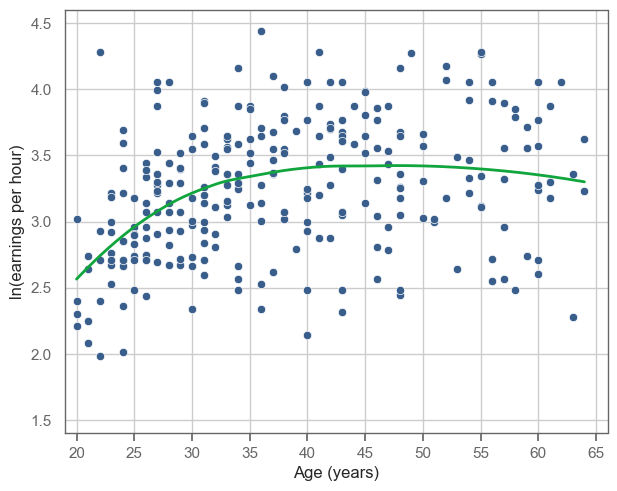

In [24]:
sns.scatterplot(data=data, x="age", y="lnw")
da.plot_loess(data=data, x="age", y="lnw",span=0.8,color=da.color[1])
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("ln(earnings per hour)", fontsize=12)
plt.xlim(19, 66)
plt.xticks(np.arange(20, 66, 5))  
plt.ylim(1.4, 4.6)
plt.yticks(np.arange(1.5, 4.6, 0.5))  


plt.show()

In [25]:
z = reg4.get_prediction().conf_int()


In [26]:
res = reg4.get_prediction().summary_frame()
data["lnwpred_ageq"] = res["mean"]
data["lnwpred_ageqCIUP"] = [x[0] for x in z]
data["lnwpred_ageqCILO"] = [x[1] for x in z]


In [27]:
z = reg5.get_prediction().conf_int()


In [28]:
res = reg5.get_prediction().summary_frame()
data["lnwpred_agesp"] = res["mean"]
data["lnwpred_agespCIUP"] = [x[0] for x in z]
data["lnwpred_agespCILO"] = [x[1] for x in z]


In [29]:
data["lnwpred_agel"] = reg6.fit()[0]


(b) Lowess, piecewise linear spline, and quadratic

In [30]:
plotdata = data.filter(["age", "lnwpred_agel", "lnwpred_ageq", "lnwpred_agesp"]).melt(
    id_vars=["age"]
)

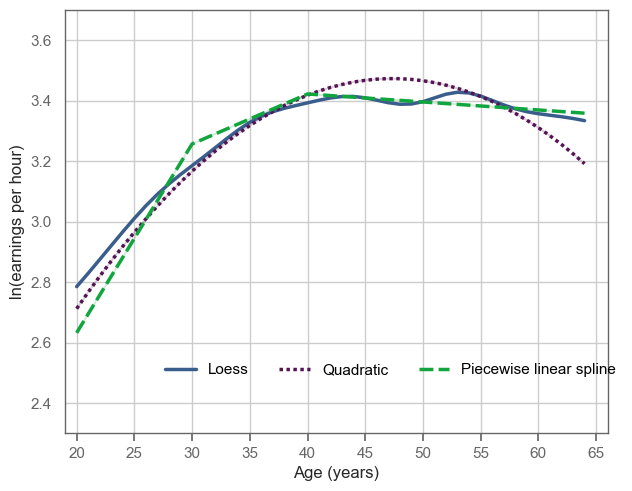

In [ ]:
palette = {
    "lnwpred_agel": da.color[0],
    "lnwpred_ageq": da.color[2],
    "lnwpred_agesp": da.color[1]
}
legend_labels = {
    "lnwpred_agel": "Loess",
    "lnwpred_ageq": "Quadratic",
    "lnwpred_agesp": "Piecewise linear spline"
}

sns.lineplot(
    data=plotdata,
    x="age",
    y="value",
    hue="variable",
    style="variable",
    palette=palette,
    style_order=["lnwpred_agel","lnwpred_agesp","lnwpred_ageq"],
    linewidth=2.5
)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels if label in legend_labels]
plt.legend(
    handles=handles[:len(new_labels)],
    labels=new_labels,
    title="",
    loc="lower center",
    bbox_to_anchor=(0.6, 0.1),
    ncol=3,
    frameon=False
)

plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("ln(earnings per hour)", fontsize=12)
plt.xlim(19, 66)
plt.xticks(np.arange(20, 66, 5))  
plt.ylim(2.3, 3.7)
plt.yticks(np.arange(2.4, 3.7, 0.2))  

plt.show()

### Figure 9.4 Average log earnings and age: regressions with CI

In [32]:
plotdata = (
    data.filter(
        [
            "age",
            "lnwpred_agel",
            "lnwpred_ageq",
            "lnwpred_agesp",
            "lnwpred_ageqCIUP",
            "lnwpred_ageqCILO",
            "lnwpred_agespCIUP",
            "lnwpred_agespCILO",
        ]
    )
    .melt(id_vars=["age"])
    .assign(CI=lambda x: x["variable"].str.contains("CI"))
    .assign(
        estimate=lambda x: np.where(x["CI"], x["variable"].str[:-4], x["variable"]),
    )
)

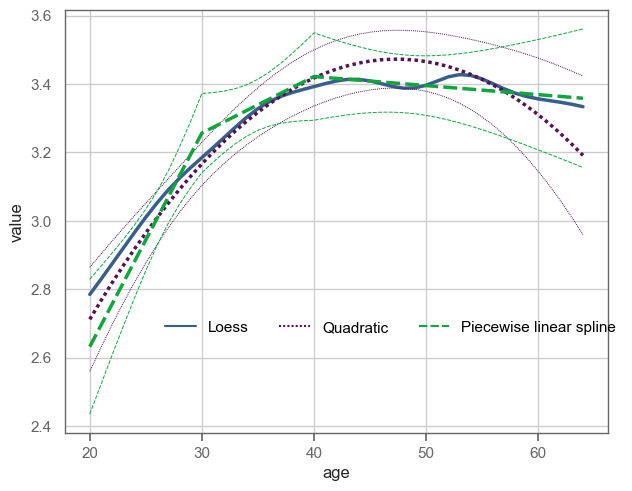

In [33]:
palette = {
    "lnwpred_agel": da.color[0],
    "lnwpred_ageq": da.color[2],
    "lnwpred_agesp": da.color[1]
}

legend_labels = {
    "lnwpred_agel": "Loess",
    "lnwpred_ageq": "Quadratic",
    "lnwpred_agesp": "Piecewise linear spline"
}

sns.lineplot(
    data=plotdata,
    x="age",
    y="value",
    hue="estimate",
    style="estimate",
    size="CI",
    palette=palette,
    style_order=["lnwpred_agel","lnwpred_agesp","lnwpred_ageq"],
    sizes={False: 2.5, True: 0.7},
    linewidth=1.5,
    units="variable",
    estimator=None
)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels if label in legend_labels]
plt.legend(
    handles=handles[1:len(new_labels)+ 1],
    labels=new_labels,
    title="",
    loc="lower center",
    bbox_to_anchor=(0.6, 0.2),
    ncol=3,
    frameon=False
)
plt.show()

### Figure 9.2 Log hourly wage and age: regression line, confidence interval, prediction interval.

In [35]:
reg7 = smf.ols(formula="lnw~age", data=data.loc[data["sample"] == 1]).fit()

(a) Confidence interval

In [36]:
pred_confidence = data.join(
    pd.DataFrame(reg7.get_prediction().conf_int(), columns=["lwr", "upr"])
).join(reg7.get_prediction().summary_frame()["mean"].rename("fit"))

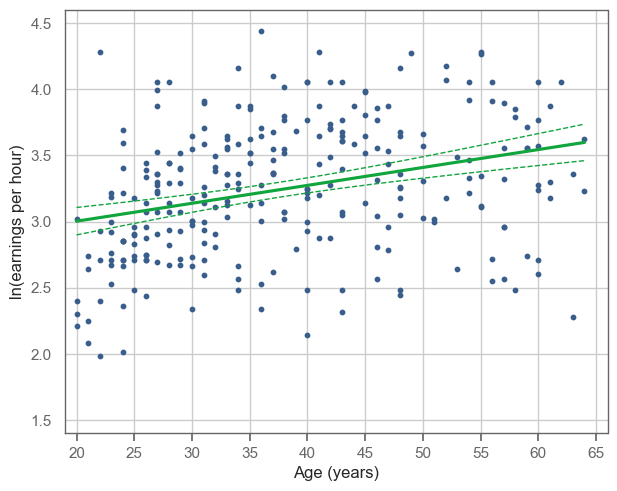

In [37]:
sns.regplot(data=pred_confidence, x="age", y="lnw",ci=False,line_kws=dict(color=da.color[1]),scatter_kws=dict(alpha = 1,s = 10))
sns.lineplot(data=pred_confidence, x="age", y="lwr",ci=False,estimator=None,linestyle = "dashed",linewidth = 1,color = da.color[1])
sns.lineplot(data=pred_confidence, x="age", y="upr",ci=False,estimator=None,linestyle = "dashed",linewidth = 1,color = da.color[1])
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("ln(earnings per hour)", fontsize=12)
plt.xlim(19, 66)
plt.xticks(np.arange(20, 66, 5))  
plt.ylim(1.4, 4.6)
plt.yticks(np.arange(1.5, 4.6, 0.5))  
plt.show()

In [38]:
pred_interval = data
pred_interval[["lwr", "upr"]] = (
    reg7.get_prediction().summary_frame().loc[:, ["obs_ci_lower", "obs_ci_upper"]]
)
pred_interval = pred_interval.join(
    reg7.get_prediction().summary_frame()["mean"].rename("fit")
)


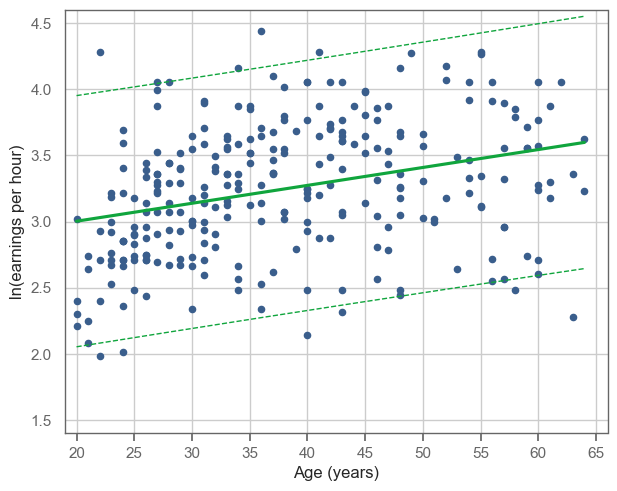

In [39]:
sns.regplot(data=pred_interval, x="age", y="lnw",ci=False,line_kws=dict(color=da.color[1]),scatter_kws=dict(alpha = 1,s = 20))
sns.lineplot(data=pred_interval, x="age", y="lwr",ci=False,estimator=None,linestyle = "dashed",linewidth = 1,color = da.color[1])
sns.lineplot(data=pred_interval, x="age", y="upr",ci=False,estimator=None,linestyle = "dashed",linewidth = 1,color = da.color[1])
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("ln(earnings per hour)", fontsize=12)
plt.xlim(19, 66)
plt.xticks(np.arange(20, 66, 5))  
plt.ylim(1.4, 4.6)
plt.yticks(np.arange(1.5, 4.6, 0.5))  
plt.show()

### Figure 9.1 Bootstrap distribution of the average female–male wage difference among market analysts

In [40]:
data = pd.read_csv(data_out + "earnings_inference.csv")


In [41]:
def bs_linreg(x, y, size=1, seed=200999):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    rng = np.random.default_rng(seed)
    # Take samples
    for i in range(size):
        bs_inds = rng.choice(inds, len(inds), replace=True)
        bs_x, bs_y = sm.add_constant(x[bs_inds]), y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = (
            sm.regression.linear_model.OLS(bs_y, bs_x).fit().params
        )

    return bs_slope_reps, bs_intercept_reps

In [42]:
results = bs_linreg(data.lnw.values, data.female.values, size=1000)

b_earnings_female = pd.DataFrame(results).T

b_earnings_female.columns = ["_b_intercept", "_b_female"]


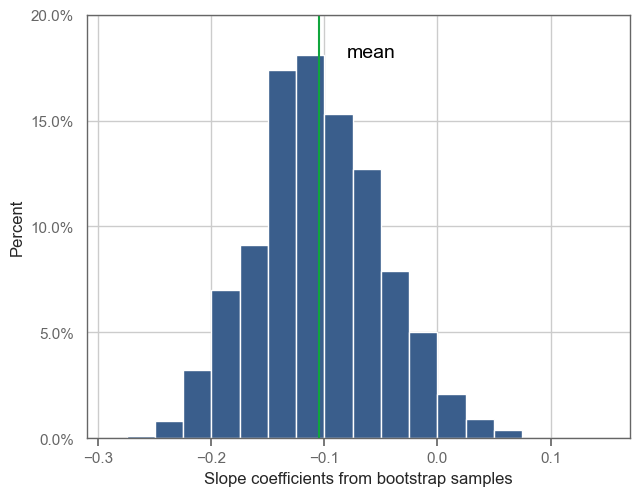

In [43]:
mean_management = b_earnings_female["_b_female"].mean()
sns.histplot(
    data=b_earnings_female,
    x="_b_female",
    binwidth=0.025,  
    binrange=(-0.3,0.1),
    color=da.color[0],
    edgecolor="white",
    stat="probability",  
    alpha=1,
)
plt.plot([mean_management,mean_management],
             [0,0.2],linewidth = 1.5,color = da.color[1])
plt.text(-0.08, 0.18, "mean", fontsize=14)

plt.xlabel("Slope coefficients from bootstrap samples")
plt.ylabel("Percent")
plt.ylim(0, 0.2)
plt.yticks(ticks=np.arange(0, 0.21, 0.05))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlim(-0.31, 0.17)
plt.xticks(ticks=np.arange(-0.3, 0.11, 0.1))
plt.show()